## We need to download the data for evaluation purposes.

In [35]:

## unocomment the following lines to install azure dependencies.
# ! pip install azure-core==1.30.1
# ! pip install azure-storage-blob==12.19.1
# !pip install opencv-python

In [2]:
from azure.storage.blob import BlobClient

def download_data(sas_url):
    """
        This function takes a sas url from azure blob storage and download that blob in the current working directory.
    """
    blob_client = BlobClient.from_blob_url(sas_url)
    with open(file=blob_client.blob_name, mode="wb") as blob_file:
        download_stream = blob_client.download_blob()
        blob_file.write(download_stream.readall())

In [3]:
download_data("<PUT THE SECRET URL HERE TO DOWNLOAD DATA>")

In [34]:
!unzip archive.zip

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

2024-04-13 17:59:45.763818: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 17:59:45.789682: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 17:59:45.845821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 17:59:46.876948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append((resized_arr, class_num))
            except Exception as e:
                print(e)
    # print(data)
    return data

In [5]:
train = get_training_data('<training_directory>')
test = get_training_data('<test_directory>')
val = get_training_data('validation_directory')

<Axes: xlabel='count'>

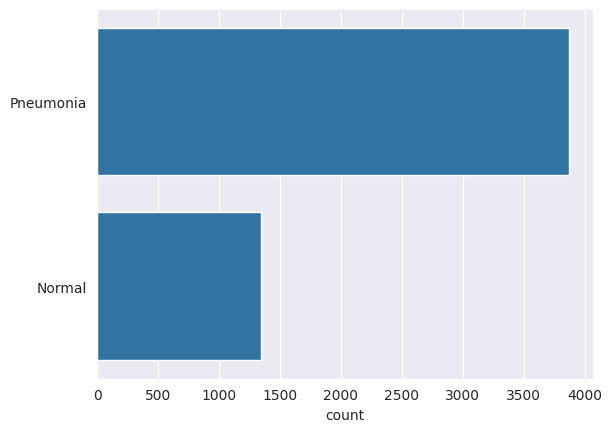

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

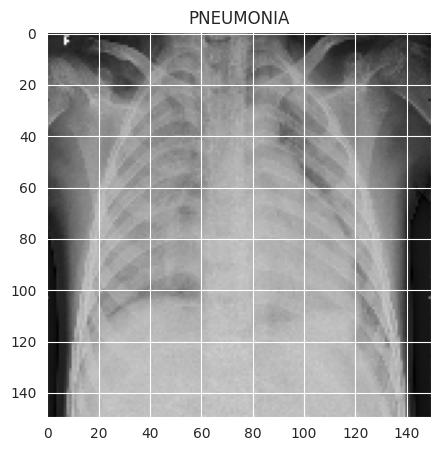

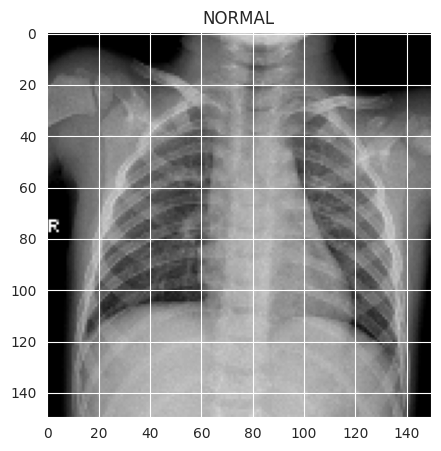

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [9]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [12]:
DO_TRAINING = False

In [16]:
if DO_TRAINING:
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.summary()
else:
    import tensorflow
    model = tensorflow.keras.models.load_model('cnn_model.h5')
    model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])


In [17]:
if DO_TRAINING:
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
    history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

In [18]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9097 - loss: 0.2571
Loss of the model is -  0.27635058760643005
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9097 - loss: 0.2571
Accuracy of the model is -  90.06410241127014 %


In [36]:
if DO_TRAINING:
    epochs = [i for i in range(12)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    
    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [ ]:
if DO_TRAINING:
    model.save('cnn_model.h5')

In [20]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step


array([4.19899672e-02, 4.80650142e-02, 1.64050937e-01, 3.25124636e-02,
       8.42280967e-11, 1.25460545e-07, 1.21167764e-01, 3.66368830e-01,
       2.50402659e-01, 2.46097341e-01, 2.45197713e-01, 1.36141432e-02,
       3.76571494e-04, 4.84603746e-11, 8.97980357e-09], dtype=float32)

In [21]:
predictions.shape

(624,)

In [24]:
predictions = np.round(predictions)

In [26]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.90      0.92       390
   Normal (Class 1)       0.85      0.90      0.87       234

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.90       624
       weighted avg       0.90      0.90      0.90       624



In [27]:
cm = confusion_matrix(y_test,predictions)
cm

array([[352,  38],
       [ 24, 210]])

In [29]:
import pandas as pd
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

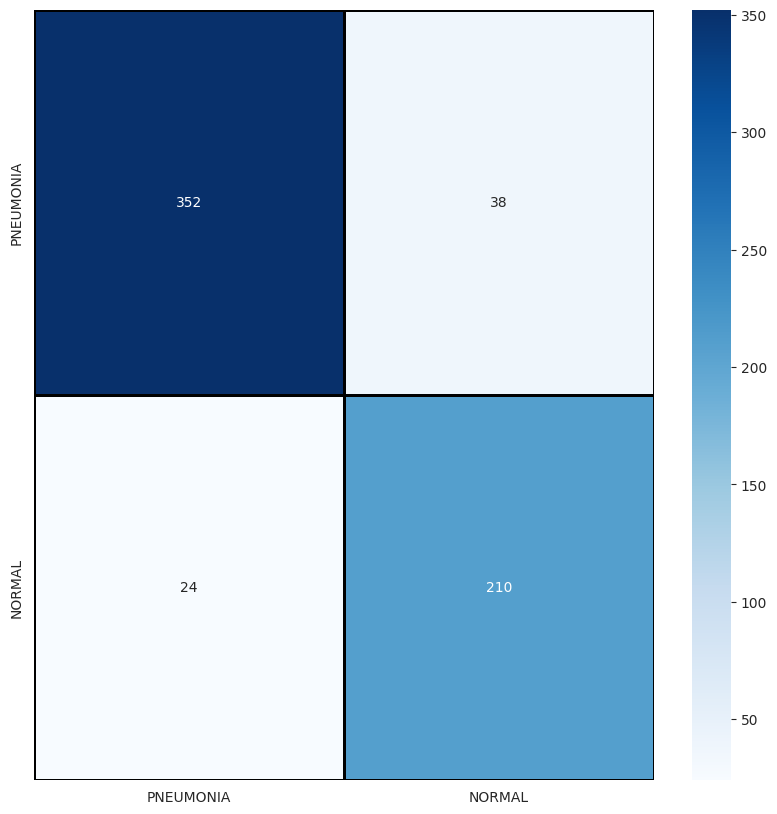

In [30]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [31]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

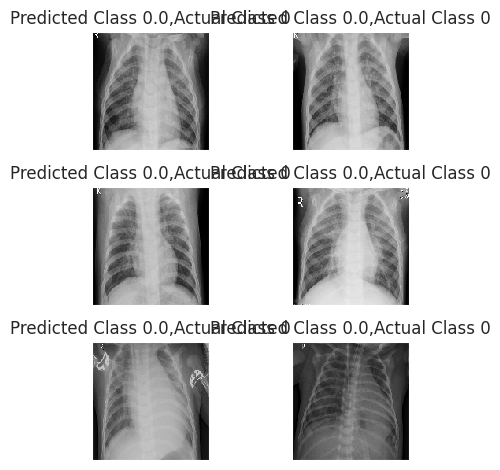

In [32]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

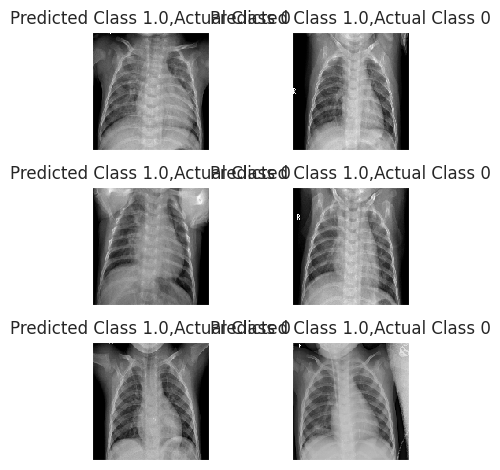

In [33]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1